# LSTM Forecasting

## Prepare de data

First, we read the dataset with pandas and explore the nature of the data.

In [1]:
import pandas as pd
original_dataset = pd.read_csv('full_dataset.csv')
print(original_dataset.shape)
original_dataset.tail()

(9942, 13)


,date,price_eurusd,open_eurusd,high_eurusd,low_eurusd,change_eurusd,bid,ask,price_sp500,open_sp500,high_sp500,low_sp500,change_sp500
9937,6/27/2022,1.06,1.06,1.06,1.05,0.26,695.55,689.88,3900.11,3920.76,3927.72,3889.66,-0.30
9938,6/28/2022,1.05,1.06,1.06,1.05,-0.61,693.59,685.75,3821.55,3913.00,3945.86,3820.14,-2.01
9939,6/29/2022,1.04,1.05,1.05,1.04,-0.75,692.96,686.23,3818.83,3825.09,3836.50,3799.02,-0.07
9940,6/30/2022,1.05,1.04,1.05,1.04,0.41,692.25,684.76,3785.38,3785.99,3818.99,3738.67,-0.88
9941,7/1/2022,1.04,1.05,1.05,1.04,-0.52,693.69,685.26,3825.33,3781.00,3829.82,3752.10,1.06


We have to define which columns will be used to predict. In this particular case, we use `price_eurusd` and `price_sp500` as inputs and `bid` as the target. We use `.values` to get the numpy array.

In [2]:
import numpy as np

in_seq1 = original_dataset["price_eurusd"].values
in_seq2 =  original_dataset["price_sp500"].values
out_seq = original_dataset["bid"].values

print(in_seq1.shape, in_seq2.shape, out_seq.shape)
print(in_seq1)

(9942,) (9942,) (9942,)
[0.98 0.99 0.99 ... 1.04 1.05 1.04]


We have to transform the arrays in a single array. For that, first we reshape the arrays to have matrixes with one column.

In [3]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
print(in_seq1.shape, in_seq2.shape, out_seq.shape)
print(in_seq1)

(9942, 1) (9942, 1) (9942, 1)
[[0.98]
 [0.99]
 [0.99]
 ...
 [1.04]
 [1.05]
 [1.04]]


Then, we "merge" the matrixes to have a single matrix. Each row is a time step and each column is a separate time series.

In [4]:
dataset = np.hstack((in_seq1, in_seq2, out_seq))
print(dataset.shape)
print(dataset)

(9942, 3)
[[9.80000e-01 1.41300e+02 4.54500e+01]
 [9.90000e-01 1.42000e+02 4.54500e+01]
 [9.90000e-01 1.45300e+02 4.54500e+01]
 ...
 [1.04000e+00 3.81883e+03 6.92960e+02]
 [1.05000e+00 3.78538e+03 6.92250e+02]
 [1.04000e+00 3.82533e+03 6.93690e+02]]


The `split_sequences` method iterates through the sequences to split them in `X` and `y` data. The `X` is the input group by n_steps. Note that it has `y` is just an array of the `bid` values.

In [5]:
# Split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
# Number of time steps
n_steps = 6

# Convert into input/output
X_train, y_train = split_sequences(dataset, n_steps)
print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)

# The dataset knows the number of features
n_features = X_train.shape[2]

(9937, 6, 2)
[[[9.80000e-01 1.41300e+02]
  [9.90000e-01 1.42000e+02]
  [9.90000e-01 1.45300e+02]
  [9.90000e-01 1.45200e+02]
  [9.90000e-01 1.46800e+02]
  [9.90000e-01 1.45800e+02]]

 [[9.90000e-01 1.42000e+02]
  [9.90000e-01 1.45300e+02]
  [9.90000e-01 1.45200e+02]
  [9.90000e-01 1.46800e+02]
  [9.90000e-01 1.45800e+02]
  [9.80000e-01 1.46700e+02]]

 [[9.90000e-01 1.45300e+02]
  [9.90000e-01 1.45200e+02]
  [9.90000e-01 1.46800e+02]
  [9.90000e-01 1.45800e+02]
  [9.80000e-01 1.46700e+02]
  [9.90000e-01 1.45700e+02]]

 ...

 [[1.06000e+00 3.75989e+03]
  [1.05000e+00 3.79573e+03]
  [1.06000e+00 3.91174e+03]
  [1.06000e+00 3.90011e+03]
  [1.05000e+00 3.82155e+03]
  [1.04000e+00 3.81883e+03]]

 [[1.05000e+00 3.79573e+03]
  [1.06000e+00 3.91174e+03]
  [1.06000e+00 3.90011e+03]
  [1.05000e+00 3.82155e+03]
  [1.04000e+00 3.81883e+03]
  [1.05000e+00 3.78538e+03]]

 [[1.06000e+00 3.91174e+03]
  [1.06000e+00 3.90011e+03]
  [1.05000e+00 3.82155e+03]
  [1.04000e+00 3.81883e+03]
  [1.05000e+00 3.78

## LSTM Model

We define a method to build the LSTM model.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def build_lstm_model(steps, features):
    model = Sequential()    
    model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) # The prediction is one value.
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=["mean_absolute_error"])
    return model

model = build_lstm_model(n_steps, n_features)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 50)             10600     
                                                                 
 dropout (Dropout)           (None, 6, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 6, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

Then, we just need to train the model with 130 epochs. It will take some time to finish.

In [8]:
model.fit(X_train, y_train, epochs=130)

Epoch 1/130
311/311 [==============================] - 5s 5ms/step - loss: 150197.0781 - mean_absolute_error: 329.5056
Epoch 2/130
311/311 [==============================] - 2s 5ms/step - loss: 139165.6719 - mean_absolute_error: 312.3062
Epoch 3/130
311/311 [==============================] - 2s 5ms/step - loss: 129813.5859 - mean_absolute_error: 297.6263
Epoch 4/130
311/311 [==============================] - 2s 5ms/step - loss: 121185.4844 - mean_absolute_error: 285.2555
Epoch 5/130
311/311 [==============================] - 2s 5ms/step - loss: 113170.7031 - mean_absolute_error: 274.4794
Epoch 6/130
311/311 [==============================] - 2s 5ms/step - loss: 105720.0234 - mean_absolute_error: 265.0324
Epoch 7/130
311/311 [==============================] - 2s 5ms/step - loss: 98920.5000 - mean_absolute_error: 256.6945
Epoch 8/130
311/311 [==============================] - 2s 5ms/step - loss: 92651.8359 - mean_absolute_error: 248.6852
Epoch 9/130
311/311 [=============================

## Prediction - First example

In [9]:
x_input = np.array([[1.06, 3911.74], [1.06, 3900.11], [1.05, 3821.55], [1.04, 3818.83], [1.05, 3785.38], [1.04, 3825.33]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[606.8222]]


## Predictions - July

In [10]:
current_data = pd.read_csv('current_data_july.csv', usecols = ['price_eurusd', 'price_sp500']).values

X_input_current_data = []

for index in range(len(current_data)):
    temp_array = []
    if(index + n_steps <= len(current_data)):
        for index2 in range(n_steps):
            temp_array.append(current_data[index + index2].tolist())
        X_input_current_data.append(temp_array)

rows_count = len(X_input_current_data)
X_input_current_data = np.array(X_input_current_data)
X_input_current_data = X_input_current_data.reshape((rows_count, n_steps, n_features))
predictions_current_data = model.predict(X_input_current_data).flatten()
predictions_current_data

1/1 [==============================] - 0s 13ms/step


array([606.8052 , 606.79456, 606.7825 , 606.7648 , 606.7673 , 606.7692 ],
      dtype=float32)

## Predictions - X_train

311/311 [==============================] - 1s 2ms/step


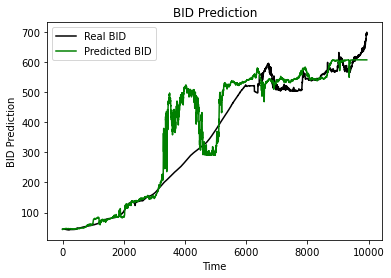

In [11]:
import matplotlib.pyplot as plt

train_predictions = model.predict(X_train).flatten()
real_bid = original_dataset["bid"]

plt.plot(real_bid, color = "black", label="Real BID")
plt.plot(train_predictions, color="green", label="Predicted BID")
plt.title("BID Prediction")
plt.xlabel("Time")
plt.ylabel("BID Prediction")
plt.legend()
plt.show()